# Sitemap Assay

A playground for seeing how we can eval sitemaps up front.

Doesn't actually do anything yet that would do that.  ;) 

References:
* [AdvTools](https://advertools.readthedocs.io/en/master/advertools.sitemaps.html)
* [Sitemap viz](https://www.ayima.com/us/insights/analytics-and-cro/how-to-visualize-an-xml-sitemap-using-python.html)

## Notes

Some commands of note

```
 curl -s https://geoconnex.us/sitemap/nhdplusv2/huc12pp/huc12pp__1.xml |  grep -oP '<loc>\K[^<]*'
 ```
 
 
 The following exposes GeoJSON, not JSON-LD
 
 ```
 curl -LH "Accept: application/ld+json"   https://geoconnex.us/nhdplusv2/huc12/030601020107
 ```
 


In [2]:
import advertools as adv

In [3]:
%%time 
%%capture cap --no-stderr  --no-stdout

iow_sitemap = adv.sitemap_to_df('https://edmo.seadatanet.org/sitemap.xml')
# iow_sitemap = adv.sitemap_to_df('https://geoconnex.us/sitemap.xml')


2021-12-10 22:02:32,692 | INFO | sitemaps.py:419 | sitemap_to_df | Getting https://edmo.seadatanet.org/sitemap.xml


CPU times: user 62.3 ms, sys: 22.8 ms, total: 85.1 ms
Wall time: 1.64 s


In [4]:
iow_sitemap['loc'] = iow_sitemap['loc'].astype('str')
# iow_sitemap.dtypes

In [5]:
iow_sitemap.head()

,loc,lastmod,sitemap,sitemap_size_mb,download_date
0,https://edmo.seadatanet.org/,NaT,https://edmo.seadatanet.org/sitemap.xml,0.386235,2021-12-11 04:02:32.704136+00:00
1,https://edmo.seadatanet.org/search,NaT,https://edmo.seadatanet.org/sitemap.xml,0.386235,2021-12-11 04:02:32.704136+00:00
2,https://edmo.seadatanet.org/sparql,NaT,https://edmo.seadatanet.org/sitemap.xml,0.386235,2021-12-11 04:02:32.704136+00:00
3,https://edmo.seadatanet.org/report/5484,2021-12-09 00:00:00+00:00,https://edmo.seadatanet.org/sitemap.xml,0.386235,2021-12-11 04:02:32.704136+00:00
4,https://edmo.seadatanet.org/report/5485,2021-12-09 00:00:00+00:00,https://edmo.seadatanet.org/sitemap.xml,0.386235,2021-12-11 04:02:32.704136+00:00


## Unique Sitemaps URLs and resource URLs in IoW

We can quickly grabe the unique URLs from the sitemap column and see how many unique sitemap.xml files we are working with

In [6]:
usm = iow_sitemap.sitemap.unique()
uloc = iow_sitemap["loc"].unique()
print("There are {} unique sitemap XML files pointing to {} unique resources of interest".format(len(usm), len(uloc)))

There are 1 unique sitemap XML files pointing to 4509 unique resources of interest


## Analyzing the URLs

We can also dive into the URL structure a bit.  Since the base for the URLs is all the same with geoconnex.us, we can drop down to the next level of the URL and see what that tells us.

In [7]:
# Break down all the URL into theor path parts
urldf = adv.url_to_df(list(iow_sitemap['loc']))
urldf.head()

,url,scheme,netloc,path,query,fragment,dir_1,dir_2
0,https://edmo.seadatanet.org/,https,edmo.seadatanet.org,/,,,NaN,NaN
1,https://edmo.seadatanet.org/search,https,edmo.seadatanet.org,/search,,,search,NaN
2,https://edmo.seadatanet.org/sparql,https,edmo.seadatanet.org,/sparql,,,sparql,NaN
3,https://edmo.seadatanet.org/report/5484,https,edmo.seadatanet.org,/report/5484,,,report,5484
4,https://edmo.seadatanet.org/report/5485,https,edmo.seadatanet.org,/report/5485,,,report,5485


In [9]:
# We can not aggregate at various levels...   
e4 = urldf["dir_1"].value_counts()
e4.rename_axis("sources")

e4df = e4.to_frame()
e4df.head(len(e4)) 

,dir_1
report,4506
sparql,1
search,1


In [11]:
# With a little trial and error we can see the cutoff for a chart 
ts = e4df.tail(10)['dir_1'].sum()
print(ts)

4508


In [12]:
e4topdf = e4df.head(6)  ## don't do this!
e4topdf.reset_index(inplace = True, drop = False)
e4topdf.rename(columns={'index': 'source', 'dir_4':'count'},  inplace = True)

t = e4topdf.append({'source':'other', 'count':ts}, ignore_index=True) 
t.head(10)

/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,source,dir_1,count
0,report,4506.0,NaN
1,sparql,1.0,NaN
2,search,1.0,NaN
3,other,NaN,4508.0


<AxesSubplot:ylabel='count'>

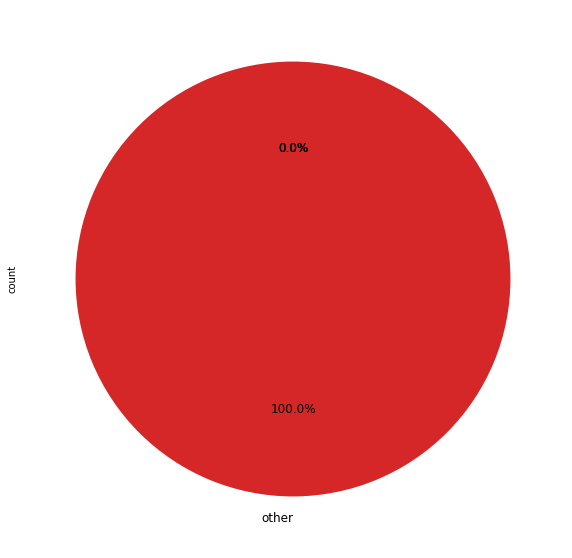

In [13]:
import matplotlib.pyplot as plt
from pandas.plotting import table

plt.figure(figsize=(30,10))

# plot chart
ax1 = plt.subplot(121, aspect='equal')
t.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=t['source'], legend = False, fontsize=12)

# # plot table
# ax2 = plt.subplot(122,  aspect='equal')
# plt.axis('off')
# tbl = table(ax2, t, loc='center')
# tbl.auto_set_font_size(False)
# tbl.set_fontsize(12)
# plt.show()

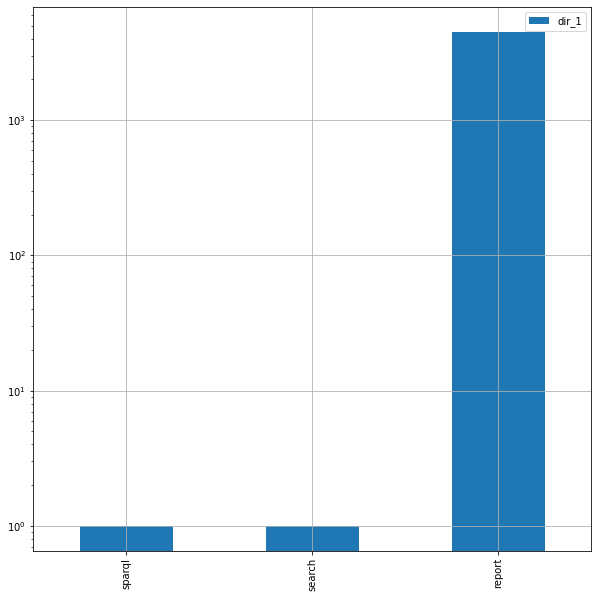

In [14]:
e4sort = e4.sort_values(ascending=True)
plot = e4sort.plot.bar(y='dir_4',legend=True, grid=True, logy = True, figsize=(10, 10))

## Let's try and set a sample from the various sites

In [16]:
# sample the previously generated url data frame
sample_df = urldf.groupby("dir_1").sample(n=2, random_state=1, replace=True)


In [17]:
sample_df.head()

,url,scheme,netloc,path,query,fragment,dir_1,dir_2
238,https://edmo.seadatanet.org/report/227,https,edmo.seadatanet.org,/report/227,,,report,227
3983,https://edmo.seadatanet.org/report/2201,https,edmo.seadatanet.org,/report/2201,,,report,2201
1,https://edmo.seadatanet.org/search,https,edmo.seadatanet.org,/search,,,search,NaN
1,https://edmo.seadatanet.org/search,https,edmo.seadatanet.org,/search,,,search,NaN
2,https://edmo.seadatanet.org/sparql,https,edmo.seadatanet.org,/sparql,,,sparql,NaN


In [18]:
import urllib.request
import requests

ul = sample_df["url"]

for item in ul:
    headers, code, dtype = None, None, None
    
    try:
        x = requests.head(item)
        code = x.status_code
        with urllib.request.urlopen(item) as response:
            info = response.info()
            dtype = info.get_content_type()    # -> text/html

        # headers = x.headers()
    except:
        code = "error"
        dtype = "error"
        headers = "error"
    
    print("{}: {} : {} : {}".format(code, dtype, item, headers))

200: text/html : https://edmo.seadatanet.org/report/227 : None
200: text/html : https://edmo.seadatanet.org/report/2201 : None
200: text/html : https://edmo.seadatanet.org/search : None
200: text/html : https://edmo.seadatanet.org/search : None
200: text/html : https://edmo.seadatanet.org/sparql : None
200: text/html : https://edmo.seadatanet.org/sparql : None
